<a href="https://colab.research.google.com/github/lewisevans38/Suez-Time-Series-Anomaly-Detection-/blob/main/RNNonNABambient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This model intends to show the difficulty with training a model on anomalous data without prior knowledge of where the anomaly is.

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from matplotlib import pyplot as plt
import statistics
import math

In [ ]:
URL = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv"
DATA1 = pd.read_csv(URL)

df  = DATA1
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(-1,1))
scaler = scaler.fit(train[['value']])
train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])
df['value'] = scaler.transform(df[['value']])



(6903, 2) (364, 2)


<ipython-input-32-936f95c3d37e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['value'] = scaler.transform(train[['value']])
<ipython-input-32-936f95c3d37e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = scaler.transform(test[['value']])


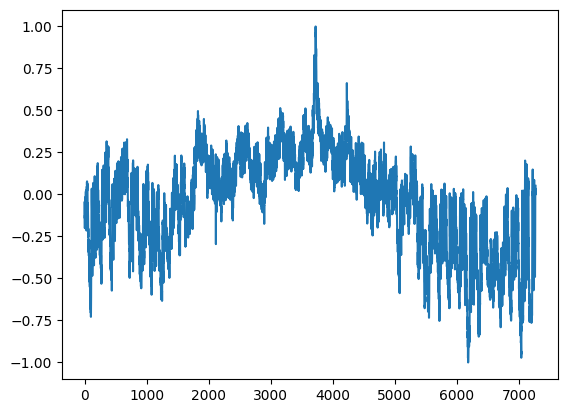

In [ ]:
fig, ax = plt.subplots()
DATA1.plot(legend=False, ax=ax)
plt.show()

In [ ]:
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 6
BATCH_SIZE = 6
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
  train[['value']],
  train.value,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  test[['value']],
  test.value,
  TIME_STEPS
)


##Turn into pytorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return(len(self.X))

  def __getitem__(self , i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class RNN(nn.Module):
  def __init__(self,input_size, hidden_size):
    super().__init__()
    self.hidden_size=hidden_size

    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

    self.fc=nn.Linear(hidden_size, 1)


  def forward(self,x):
    batch_size = x.size(0)
    h0 = torch.zeros(1,batch_size, self.hidden_size)
    out,_ =self.rnn(x,h0)
    out = self.fc(out[:,-1,:])
    return out

model = RNN(1,TIME_STEPS)
model

RNN(
  (rnn): RNN(1, 6, batch_first=True)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch+1}')
  running_loss =0.0
  running_loss1=0.0
  avg_loss_across_batches = 0
  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0], batch[1]
    output= torch.squeeze(model(x_batch))
    loss = loss_fn(output,y_batch) # comparing model output to ground truth
    running_loss += loss
    running_loss1 += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index %100 == 99:
      avg_loss_across_batches = running_loss/100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
      running_loss =0.0

  return running_loss1.item()/(len(train_loader))

def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0], batch[1]

    with torch.no_grad():
      output= torch.squeeze(model(x_batch))
      loss = loss_fn(output,y_batch)
      running_loss += loss
  avg_loss_across_batches = running_loss.item() /len(test_loader)

  print('Val Loss : {0:.3f}'.format(avg_loss_across_batches))
  print('************************************************')
  return avg_loss_across_batches

In [ ]:
lr = 0.001
num_epochs = 35
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
trainingloss = []
val_loss = []
for epoch in range(num_epochs):
  trainingloss.append(train_one_epoch())
  val_loss.append(validate_one_epoch())


Epoch: 1
Batch 100, Loss: 0.070
Batch 200, Loss: 0.046
Batch 300, Loss: 0.034
Batch 400, Loss: 0.024
Batch 500, Loss: 0.013
Batch 600, Loss: 0.011
Batch 700, Loss: 0.021
Batch 800, Loss: 0.012
Batch 900, Loss: 0.020
Batch 1000, Loss: 0.024
Batch 1100, Loss: 0.019
Val Loss : 0.016
************************************************
Epoch: 2
Batch 100, Loss: 0.006
Batch 200, Loss: 0.006
Batch 300, Loss: 0.004
Batch 400, Loss: 0.004
Batch 500, Loss: 0.003
Batch 600, Loss: 0.003
Batch 700, Loss: 0.005
Batch 800, Loss: 0.004
Batch 900, Loss: 0.004
Batch 1000, Loss: 0.006
Batch 1100, Loss: 0.007
Val Loss : 0.010
************************************************
Epoch: 3
Batch 100, Loss: 0.004
Batch 200, Loss: 0.005
Batch 300, Loss: 0.003
Batch 400, Loss: 0.004
Batch 500, Loss: 0.003
Batch 600, Loss: 0.003
Batch 700, Loss: 0.005
Batch 800, Loss: 0.003
Batch 900, Loss: 0.004
Batch 1000, Loss: 0.006
Batch 1100, Loss: 0.006
Val Loss : 0.008
************************************************
Epoch: 4
B

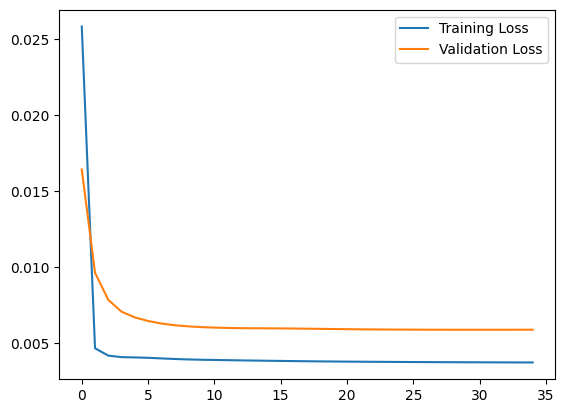

In [ ]:
plt.plot(trainingloss, label = 'Training Loss')
plt.plot(val_loss, label ='Validation Loss')
#plt.title(label= 'Training Loss for sequence length 100 ')
plt.legend()
plt.show()

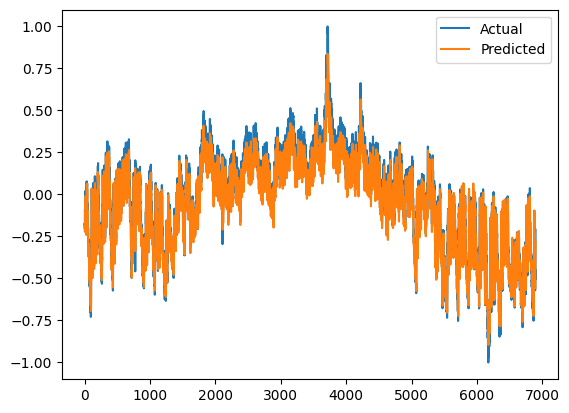

In [ ]:
predicted = model(X_train).detach().numpy()
y_train.numpy()
plt.plot(y_train.numpy(), label = 'Actual')
plt.plot(predicted, label ='Predicted')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

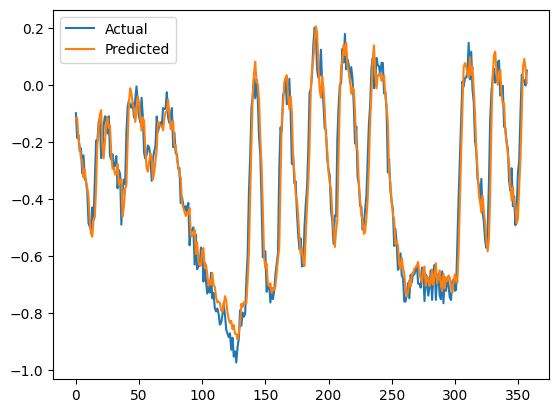

In [ ]:
predicted1 = model(X_test).detach().numpy()
plt.plot(y_test.numpy(), label = 'Actual')
plt.plot(predicted1, label = 'Predicted')
plt.legend()
plt.show

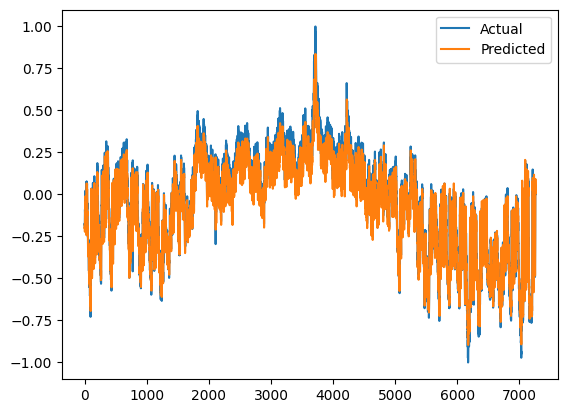

In [ ]:
##Anomaly detection step
#Re-feed the entire dataset into the model

Xs, ys = create_dataset(df[['value']],df.value, TIME_STEPS)

Xs = torch.tensor(Xs).float()
ys = torch.tensor(ys).float()


with torch.no_grad():
  predicted2 = model(Xs).numpy()

plt.plot(ys, label = 'Actual')
plt.plot(predicted2, label ='Predicted')
plt.legend()
plt.show()

In [ ]:
indextracker = []
difference = []
for x in range(0,len(predicted2)):
  diff = abs(ys[x] - predicted2[x])
  difference.append(diff)
standard_deviation = np.std(difference)
Mean = np.mean(difference)
for x in range (0,len(difference)):
 if abs(difference[x]) >3*standard_deviation+ Mean:
    indextracker.append(x)
print("The anomalous points are at" , indextracker, "The total amount of anomalies is",len(indextracker))

The anomalous points are at [774, 775, 908, 1088, 1814, 2109, 2110, 3143, 3153, 3653, 3665, 3688, 3691, 3696, 3709, 3711, 3712, 3713, 3714, 3722, 3732, 3735, 3808, 3918, 4093, 4215, 4245, 4572, 4932, 5477, 5877, 5879, 5880, 5939, 6126, 7040, 7064, 7110, 7230, 7231] The total amount of anomalies is 40


In [ ]:
for x in range(0,len(indextracker)):
  print(DATA1.iloc[indextracker[x]+TIME_STEPS]['timestamp'])

2013-08-06 20:00:00
2013-08-06 21:00:00
2013-08-12 10:00:00
2013-08-19 22:00:00
2013-10-01 17:00:00
2013-10-16 22:00:00
2013-10-16 23:00:00
2013-11-29 00:00:00
2013-11-29 10:00:00
2013-12-20 06:00:00
2013-12-20 18:00:00
2013-12-21 17:00:00
2013-12-21 20:00:00
2013-12-22 01:00:00
2013-12-22 14:00:00
2013-12-22 16:00:00
2013-12-22 17:00:00
2013-12-22 18:00:00
2013-12-22 19:00:00
2013-12-23 03:00:00
2013-12-23 13:00:00
2013-12-23 16:00:00
2013-12-26 17:00:00
2013-12-31 07:00:00
2014-01-07 14:00:00
2014-01-12 16:00:00
2014-01-13 22:00:00
2014-01-27 13:00:00
2014-02-11 13:00:00
2014-03-07 11:00:00
2014-03-24 19:00:00
2014-03-24 21:00:00
2014-03-24 22:00:00
2014-03-27 09:00:00
2014-04-11 09:00:00
2014-05-19 11:00:00
2014-05-20 11:00:00
2014-05-22 09:00:00
2014-05-27 09:00:00
2014-05-27 10:00:00


The actual anomalies are at

"2013-12-22 20:00:00.000000",

"2014-04-13 09:00:00.000000"

So we havent  caught any real anomalies, leaving 20 false positives.


In [ ]:
test


,timestamp,value
6903,2014-05-13 12:00:00,-0.154483
6904,2014-05-13 13:00:00,-0.178371
6905,2014-05-13 14:00:00,-0.164912
6906,2014-05-13 15:00:00,-0.100282
6907,2014-05-13 16:00:00,-0.077409
...,...,...
7262,2014-05-28 11:00:00,0.036809
7263,2014-05-28 12:00:00,0.023094
7264,2014-05-28 13:00:00,0.014306
7265,2014-05-28 14:00:00,-0.001083
